In [16]:
import os
import Locate_dir as LD
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Define directories

In [17]:
base_dir = 'images\positive_negative'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_pos_dir = os.path.join(train_dir, 'positive')
train_negs_dir = os.path.join(train_dir, 'negative')

validation_pos_dir = os.path.join(validation_dir, 'positive')
validation_negs_dir = os.path.join(validation_dir, 'negative')

## List images

In [18]:
train_pos_fnames = os.listdir( LD.location(train_pos_dir) )
train_neg_fnames = os.listdir( LD.location(train_negs_dir) )

print(train_pos_fnames[:10])
print(train_neg_fnames[:10])

['p1 - Copy (2).png', 'p1 - Copy (3).png', 'p1 - Copy (4).png', 'p1 - Copy (5).png', 'p1 - Copy.png', 'p1.png']
['n1 - Copy - Copy (2).png', 'n1 - Copy - Copy (3).png', 'n1 - Copy - Copy (4).png', 'n1 - Copy - Copy.png', 'n1 - Copy.png', 'n1.png']


## Training and validation dataset shape

In [19]:
print('total training positives images :', len(os.listdir(      train_pos_dir ) ))
print('total training negatives images :', len(os.listdir(      train_negs_dir ) ))

print('total validation positives images :', len(os.listdir( validation_pos_dir ) ))
print('total validation negatives images :', len(os.listdir( validation_negs_dir ) ))

total training positives images : 6
total training negatives images : 6
total validation positives images : 6
total validation negatives images : 6


## Show dataset

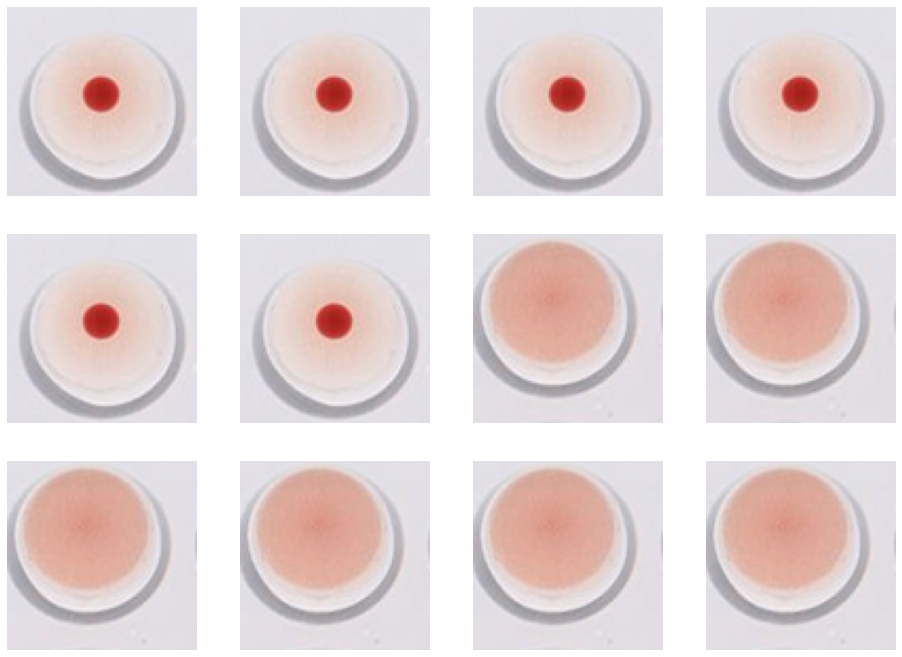

In [20]:
%matplotlib inline

nrows = 4
ncols = 4

pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_pos_pix = [os.path.join(train_pos_dir, fname) 
                for fname in train_pos_fnames[ pic_index-8:pic_index] 
               ]

next_neg_pix = [os.path.join(train_negs_dir, fname) 
                for fname in train_neg_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_pos_pix+next_neg_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [21]:
model = tf.keras.models.Sequential([
    # The input shape is the desired size of the image 90x90 with 3(or 1) bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(90, 90, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('positives') and 1 for the other ('negatives')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 88, 88, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 44, 44, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)             

In [23]:
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

## Early Stop

In [36]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.98):
            print('\nAccuracy is high, stop training!')
            self.model.stop_training = True

callback = myCallback()

## Data preprocessing

In [29]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=2,
                                                    class_mode='binary',
                                                    target_size=(90, 90))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=2,
                                                         class_mode  = 'binary',
                                                         target_size = (90, 90))


Found 12 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


## Training

In [37]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=3,
    epochs=5,
    validation_steps=2,
    verbose=2,
    callbacks=[callback])

Epoch 1/5
3/3 - 1s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 2/5
3/3 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 3/5
3/3 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 4/5
3/3 - 0s - loss: 9.4545e-04 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 5/5
3/3 - 0s - loss: 8.4572e-04 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000
